In [1]:
from collections import defaultdict

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, entropy

import sim_lib.util as util
import sim_lib.graph_networkx as gnx
import sim_lib.attr_lib.util as alu
from sim_lib.attr_lib.formation import *
import sim_lib.attr_lib.vis as vis

In [2]:
_N = 16
iter_count = 10

params = {
    'context_count' : 2, # Needed for simple utility
    'k' : 1, # Needed for simple attribute utility
    'edge_selection' : alu.seq_projection_edge_edit,
    'attr_copy' : alu.freq_attr_copy,
    'seed_type' : 'grid', # Type of seed network
    'max_clique_size' : 5,
    'revelation_proposals' : alu.resistance_distance_revelation,
    'util_agg' : lambda a, s, c: a + s, # How to aggregate utility values
    'vtx_types' :
        {
            'type1' : { 'likelihood' : 0.5,
                      'struct_util' : None,
                      'init_attrs' : alu.init_cont_heterophily, # context 1
                      'edge_attr_util' : None,
                      'total_attr_util' : None,
                      'color' : 'blue' },
            'type0' : { 'likelihood' : 0.5,
                      'struct_util' : None,
                      'init_attrs' : alu.init_cont_homophily, # context 0
                      'edge_attr_util' : None,
                      'total_attr_util' : None,
                      'color' : 'red' }
        }
}

assert sum([ t['likelihood'] for t in params['vtx_types'].values() ]) == 1.0

In [3]:
def struct_utils(G):
    return [ u.data['struct_util'](u, G) for u in G.vertices ]

def attribute_utils(G):
    return [ u.data['total_attr_util'](u, G) for u in G.vertices ]

def degrees(G):
    return [ u.degree for u in G.vertices ]

def costs(G):
    return [ alu.calc_cost(u, G) for u in G.vertices ]

In [4]:
def plot_distributions(ks_sims, kl_sims, plot_title):
    
    x_vals = list(range(iter_count))
    plt.plot(x_vals, ks_sims, label='KS score')
    plt.plot(x_vals, kl_sims, label='KL score')
    plt.xlabel('Iteration')
    plt.ylabel('Score')
    plt.title(plot_title)
    plt.legend(loc='upper right')
    plt.show()
    

[1.0, 1.0, 0.6875, 0.625, 0.1875, 0.25, 0.125, 0.4375, 0.0625, 0.3125]
[inf, 0.07062345416296692, 0.04250115281601588, 0.0185713814528971, 0.004145250377611717, 0.004195856581735286, 0.003747127176715213, 0.0023519476731149614, 0.0030841479379571206, 0.001327431684108156]


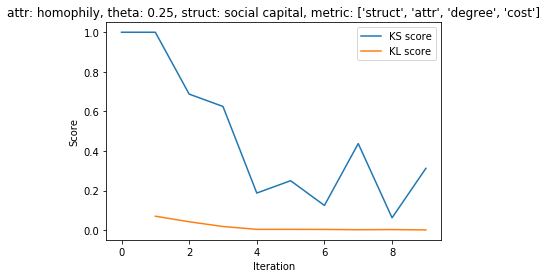

[0.4375, 0.0625, 0.0625, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0625, 0.0]
[inf, inf, 0.06453852113757116, 0.0, 0.030116479750259686, 0.0, 0.0, 0.0, 0.030116479750259686, 0.0]


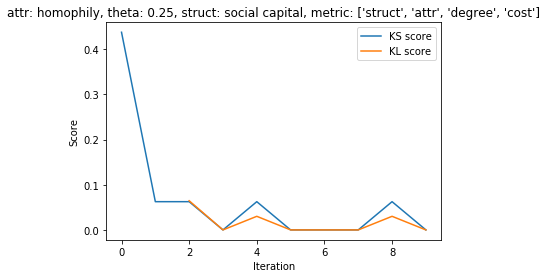

[0.9375, 0.6875, 0.375, 0.375, 0.25, 0.3125, 0.375, 0.3125, 0.5625, 0.4375]
[inf, 0.15653524562176924, 0.14251630238462962, 0.09836419042973607, 0.012817074648770216, 0.026946886828661067, 0.022440459900633362, 0.02393880691234478, 0.019731650668682828, 0.01545618972010717]


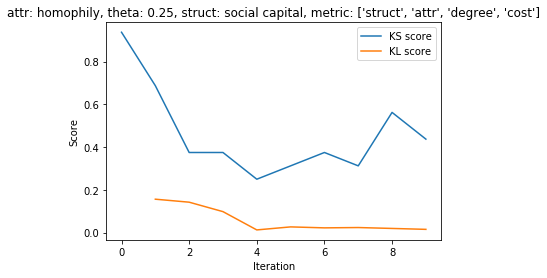

[0.9375, 0.6875, 0.375, 0.375, 0.25, 0.3125, 0.4375, 0.3125, 0.5625, 0.4375]
[inf, 0.1688195080026535, 0.14735820611633377, 0.11041107720125846, 0.01160154131526976, 0.0282181770913566, 0.02287380486909172, 0.024953350097300653, 0.019732323373284247, 0.016798730214637247]


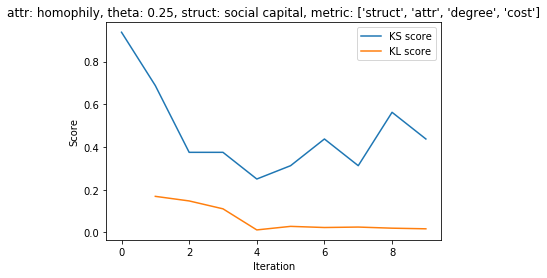

[0.9375, 0.9375, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75]
[nan, nan, inf, inf, inf, inf, inf, inf, inf, inf]


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2671: RuntimeWarning: invalid value encountered in true_divide
  qk = 1.0*qk / np.sum(qk, axis=axis, keepdims=True)


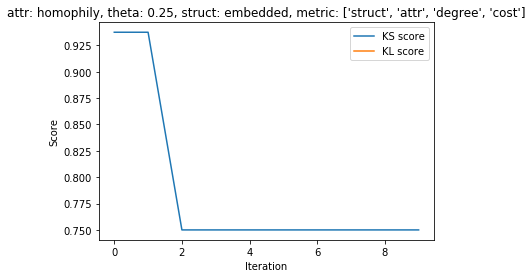

[0.1875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]


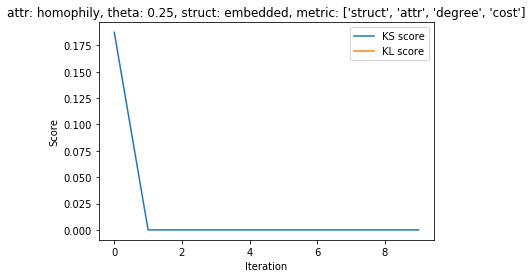

[0.9375, 0.875, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75]
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]


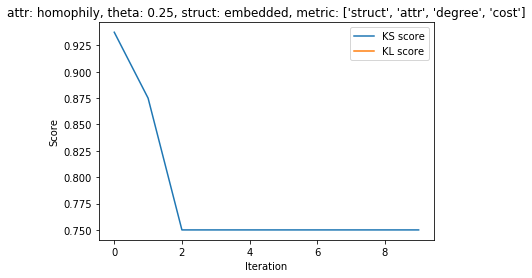

[0.9375, 0.9375, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75]
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]


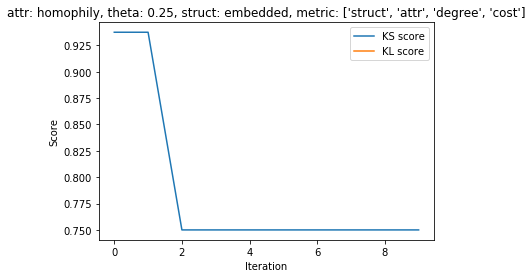

In [5]:
# Parameters
similarity_funcs = list(alu.gen_similarity_funcs())
attr_func_named = zip(similarity_funcs, ['homophily', 'heterophily'])
theta_values = [0.25, 0.5, 0.75, 1.0]
struct_funcs = [alu.ball2_size, alu.average_neighborhood_overlap]
struct_func_named = zip(struct_funcs, ['social capital', 'embedded'])
seed_types = ['grid', 'trivial']

for idx, (sim_func, af_name) in enumerate(attr_func_named):
    for theta in theta_values:
        attr_func = alu.gen_schelling_seg_funcs(theta, 'satisfice')[idx]
        for struct_func, sf_name in struct_func_named:
            for vtype in ['type0', 'type1']:
                params['vtx_types'][vtype]['struct_util'] = struct_func
                params['vtx_types'][vtype]['edge_attr_util'] = sim_func
                params['vtx_types'][vtype]['total_attr_util'] = attr_func
                
            # Run simulations
            struct_util_comp = defaultdict(list)
            attr_util_comp = defaultdict(list)
            degrees_comp = defaultdict(list)
            costs_comp = defaultdict(list)
            for seed in seed_types:
                params['seed_type'] = seed
                G = attribute_network(_N, params)
                for it in range(iter_count):
                    calc_edges(G)
                    struct_util_comp[it].append(struct_utils(G))
                    attr_util_comp[it].append(attribute_utils(G))
                    degrees_comp[it].append(degrees(G))
                    costs_comp[it].append(costs(G))
                    
            # Comparisons
            metric_name = ['struct', 'attr', 'degree', 'cost']
            metric_comps = zip(metric_name,
                               [struct_util_comp,
                                attr_util_comp,
                                degrees_comp,
                                costs_comp])
        
            for mname, mvalues in metric_comps:
                plot_title = f'attr: {af_name}, theta: {theta}, struct: {sf_name}, metric: {metric_name}'
                ks_values = [ ks_2samp(mvalues[it][0], mvalues[it][1])[0] for it in range(iter_count) ]
                kl_values = [ entropy(mvalues[it][0], mvalues[it][1]) for it in range(iter_count) ]
                print('KS', ks_values)
                print('KL', kl_values)
                plot_distributions(ks_values, kl_values, plot_title)